# Time / Space KDE algorithms

These are a general class of prediction algorithms which are motivated by the "pro-hotspot" algorithm, but which work in continuous space and time and so remove the annoying problem of choosing how to compute distances in a grid etc.  In principle, this algorithm, with well-chosen kernels, should out perform all the "classical" algorithms.  Unfortunently, the extensive use of KDEs means that this algorithm can be a little slow.

## References

1. Bowers, Johnson, Pease, "Prospective hot-spotting: The future of crime mapping?", Brit. J. Criminol. (2004) 44 641--658.  doi:10.1093/bjc/azh036
2. Rosser et al. "Predictive Crime Mapping: Arbitrary Grids or Street Networks?" Journal of Quantitative Criminology 33 (2017) 569--594 [10.1007/s10940-016-9321-x](https://link.springer.com/article/10.1007/s10940-016-9321-x)

(1) is motivation, and (2) contains an example of this class of algorithm (see page 11, equation (2) of that paper, for example).

## Algorithm

A grid is only used right at the end to produce the final prediction.

### Aim of the algorithm

We estimate a relative "risk" at the current time, and at location $x$ (a two dimensional vector) by
$$ r(x) = \sum_i f(t_i) g(x-x_i) $$
where we have events which occurred $t_i$ time units in the past, and at location $x_i$.  This is hence a combined time and space KDE method.

We then compute the average of $r$ in each grid cell to obtain the prediction (in practise we use a monte-carlo approach, and sample $r$ at random locations in each grid cell).

Our code allows complete freedom in choosing $f$ and $g$; we provide some common choices.  For the time component $f$:

- $f(t)=1$ for all $t$.  So take no account of time.
- $f(t) = e^{-\beta t}$ exponential decay.
- $f(t) = ( 1 + (x/\beta)^2 )^{-1}$ quadratic decay.

For space we use a classical KDE method:

- Either a general Gaussian KDE method, as implemented by our class `GaussianBase` (which with default parameters replicates the behaviour of the `scipy` KDE method.
- A variable bandwidth nearest neighbour estimator.  This tends to produce "clusters" which look more realistic.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp
import open_cp.kde as kde

In [2]:
# Generate some random data
import datetime
times = [datetime.datetime(2017,3,10) + datetime.timedelta(days=np.random.randint(0,10)) for _ in range(20)]
times.sort()
xc = np.random.random(size=20) * 500
yc = np.random.random(size=20) * 500
points = open_cp.TimedPoints.from_coords(times, xc, yc)

In [3]:
region = open_cp.RectangularRegion(0,500, 0,500)
predictor = kde.KDE(region=region, grid_size=50)
predictor.time_kernel = kde.ExponentialTimeKernel(1)
predictor.space_kernel = kde.GaussianBaseProvider()
predictor.data = points
gridpred = predictor.predict(samples=20)

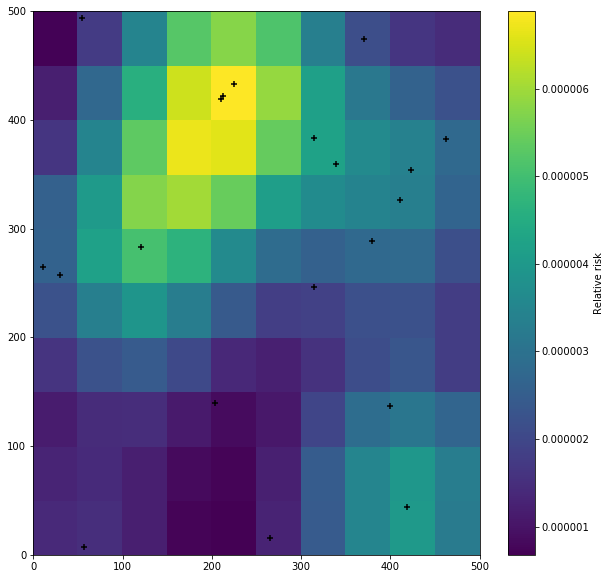

In [4]:
fig, ax = plt.subplots(figsize=(10,10))

m = ax.pcolor(*gridpred.mesh_data(), gridpred.intensity_matrix)
ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")
cb = plt.colorbar(m, ax=ax)
cb.set_label("Relative risk")
None

In [5]:
points.timestamps

array(['2017-03-10T00:00:00.000', '2017-03-10T00:00:00.000',
       '2017-03-11T00:00:00.000', '2017-03-13T00:00:00.000',
       '2017-03-13T00:00:00.000', '2017-03-13T00:00:00.000',
       '2017-03-14T00:00:00.000', '2017-03-14T00:00:00.000',
       '2017-03-14T00:00:00.000', '2017-03-16T00:00:00.000',
       '2017-03-16T00:00:00.000', '2017-03-17T00:00:00.000',
       '2017-03-17T00:00:00.000', '2017-03-18T00:00:00.000',
       '2017-03-18T00:00:00.000', '2017-03-18T00:00:00.000',
       '2017-03-18T00:00:00.000', '2017-03-19T00:00:00.000',
       '2017-03-19T00:00:00.000', '2017-03-19T00:00:00.000'], dtype='datetime64[ms]')

In [6]:
points.xcoords, points.ycoords

(array([  10.80687601,  203.91685156,  370.45133436,  264.94532001,
         338.92134828,  314.17419851,   53.99550215,  422.97038893,
         313.82997602,  399.52179916,   29.52651396,  212.27188   ,
         378.85486229,   56.75241036,  410.8388701 ,  462.25832124,
         210.65487633,  224.4827453 ,  418.81953078,  121.01936992]),
 array([ 265.17580815,  139.20982958,  474.06359622,   15.23132019,
         359.40735878,  246.54587443,  493.97658973,  353.63379925,
         383.49718973,  137.2806373 ,  257.1771003 ,  421.78195639,
         288.49195233,    6.96268501,  326.20905873,  382.40320547,
         419.20469557,  433.21287992,   44.15961916,  283.50612546]))

You can see the dependence on time: the most recent event gives much more total risk than an event far in the past.